In [9]:
import networkx as nx
import numpy as np
import pandas as pd
import subprocess

# %matplotlib notebook
%matplotlib inline

In [16]:
def barabasi_albert(n=10, m=4):
    G = nx.barabasi_albert_graph(n, m)
    G.graph["dissemination"] = "flooding"
    solving_rate = np.random.exponential(n, n).astype("d")
    for i in range(n):
        G.nodes[i]["compute"] = solving_rate[i] / np.sum(solving_rate)
    n_edges = len(G.edges)
    distance = np.random.uniform(low=1, high=3, size=n_edges)
    for (a, b) in G.edges:
        G.edges[a, b]["distance"] = distance[i]
        G.edges[a, b]["delay"] = f"uniform {distance[i] * 0.5} {distance[i] * 1.5}"
        G.edges[a, b]["spring_weight"] = 1 / distance[i]
    # distances = nx.shortest_paths()
    return G


def sim(G, protocol="nakamoto", activation_delay=1, activations=1000):
    G = G.copy()
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    with subprocess.Popen(
        ["dune", "exec", "../../simulator/bin/igraph_runner.exe"],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        return nx.parse_graphml(out)


def draw(G, size="compute", layout=None):
    G = G.copy()
    size = nx.get_node_attributes(G, size).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

In [17]:
G = barabasi_albert()
dict(nx.all_pairs_dijkstra_path_length(G, weight="distance"))

{0: {0: 0,
  1: 1.5596626184831137,
  2: 1.5596626184831137,
  3: 1.5596626184831137,
  4: 1.5596626184831137,
  5: 1.5596626184831137,
  6: 1.5596626184831137,
  7: 1.5596626184831137,
  9: 3.1193252369662274,
  8: 3.1193252369662274},
 1: {1: 0,
  0: 1.5596626184831137,
  5: 1.5596626184831137,
  6: 1.5596626184831137,
  7: 1.5596626184831137,
  9: 1.5596626184831137,
  2: 3.1193252369662274,
  3: 3.1193252369662274,
  4: 3.1193252369662274,
  8: 3.1193252369662274},
 2: {2: 0,
  0: 1.5596626184831137,
  6: 1.5596626184831137,
  1: 3.1193252369662274,
  3: 3.1193252369662274,
  4: 3.1193252369662274,
  5: 3.1193252369662274,
  7: 3.1193252369662274,
  8: 3.1193252369662274,
  9: 4.678987855449341},
 3: {3: 0,
  0: 1.5596626184831137,
  5: 1.5596626184831137,
  6: 1.5596626184831137,
  7: 1.5596626184831137,
  1: 3.1193252369662274,
  2: 3.1193252369662274,
  4: 3.1193252369662274,
  8: 3.1193252369662274,
  9: 3.1193252369662274},
 4: {4: 0,
  0: 1.5596626184831137,
  5: 1.5596626184

Entering directory '/home/patrik/devel/cpr'


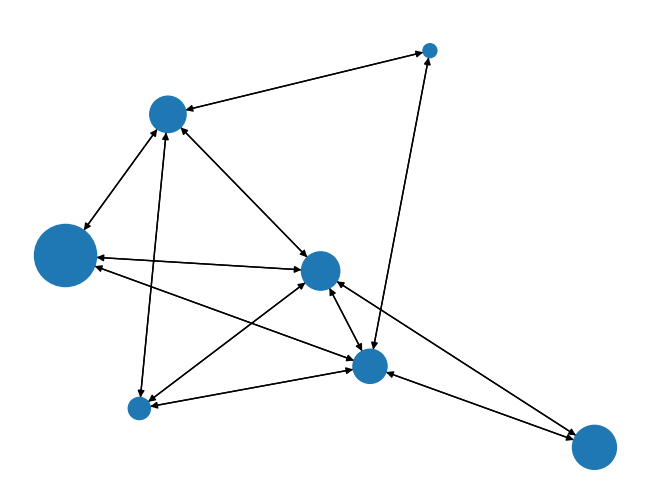

In [18]:
G = sim(barabasi_albert(n=7), activation_delay=1, activations=1000)
layout = draw(G)

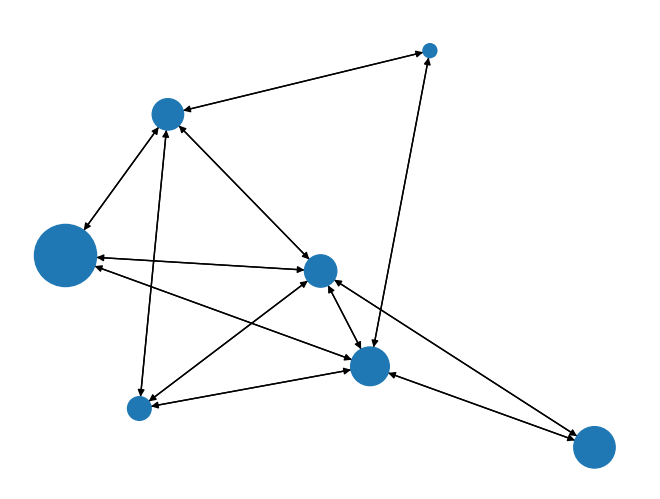

In [19]:
draw(G, size="activations", layout=layout)

In [20]:
nodes = pd.DataFrame([v for (_, v) in G.nodes.data()])
for k in ["protocol"]:
    nodes[k] = [G.graph[k] for _ in range(len(G.nodes))]
nodes["relative_reward"] = nodes.reward / np.sum(nodes.reward)
nodes["relative_activations"] = nodes.reward / np.sum(nodes.activations)
nodes["efficiency"] = nodes.reward / G.graph["head_progress"] / nodes.compute
nodes["efficiency"] = nodes.efficiency.fillna(0)
nodes

,activations,reward,compute,protocol,relative_reward,relative_activations,efficiency
0,147.0,83.0,0.127669,nakamoto,0.194836,0.083,1.526100
1,264.0,159.0,0.253294,nakamoto,0.373239,0.159,1.473543
2,101.0,23.0,0.096257,nakamoto,0.053991,0.023,0.560901
3,158.0,39.0,0.163604,nakamoto,0.091549,0.039,0.559577
4,83.0,16.0,0.082441,nakamoto,0.037559,0.016,0.455583
5,125.0,56.0,0.141799,nakamoto,0.131455,0.056,0.927055
6,122.0,50.0,0.134936,nakamoto,0.117371,0.050,0.869828
